In [1]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
import sklearn
from matplotlib import pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):

    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [2]:
#TASK 1

accuracies = np.zeros((3,sets_n))
models = [[None]*sets_n for i in range(3)]
EIGHTY = round(data_n*0.8)


for i,input in enumerate(input_variables):
    model_l1 = sklearn.linear_model.LogisticRegression(penalty='l1',C=1.0 , solver='liblinear' ,max_iter= 10000).fit(input[:EIGHTY],output_variable[:EIGHTY])
    model_l2 = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000).fit(input[:EIGHTY],output_variable[:EIGHTY])
    model_elasticnet = sklearn.linear_model.LogisticRegression(penalty='elasticnet', l1_ratio=0.5,C=1.0 , solver='saga',max_iter= 10000).fit(input[:EIGHTY],output_variable[:EIGHTY])

    models[0][i]=model_l1
    models[1][i]=model_l2
    models[2][i]=model_elasticnet


    accuracy_l1 = sum(model_l1.predict(input[EIGHTY:]) == output_variable[EIGHTY:])/output_variable[EIGHTY:].size
    accuracy_l2 = sum(model_l2.predict(input[EIGHTY:]) == output_variable[EIGHTY:])/output_variable[EIGHTY:].size
    accuracy_elasticnet = sum(model_elasticnet.predict(input[EIGHTY:]) == output_variable[EIGHTY:])/output_variable[EIGHTY:].size

    accuracies[0,i]=accuracy_l1
    accuracies[1,i]=accuracy_l2
    accuracies[2,i]=accuracy_elasticnet

accuracies*=100

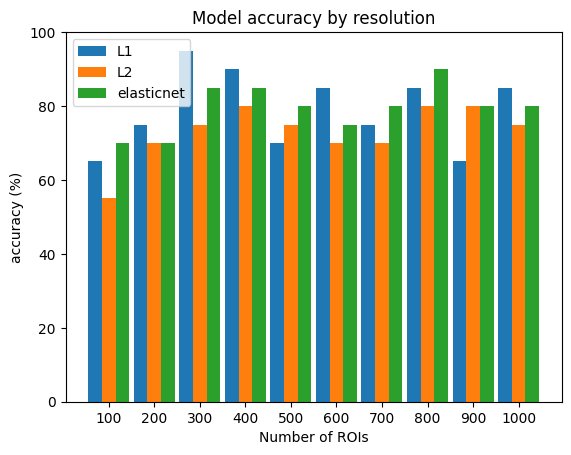

In [3]:
plt.title('Model accuracy by resolution');
plt.bar(np.arange(sets_n)-0.3,accuracies[0],width=0.3);
plt.bar(np.arange(sets_n),accuracies[1],width=0.3);
plt.bar(np.arange(sets_n)+0.3,accuracies[2],width=0.3);
plt.legend(['L1','L2','elasticnet']);
plt.ylim([0,100]);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel('Number of ROIs');
plt.ylabel('accuracy (%)');

In [4]:
#TASK 2

zero_params_total = np.zeros((3,sets_n))
zero_params_proportion = np.zeros((3,sets_n))

for i in range(sets_n):
    for j in range(3):
        zero_params_total[j,i] = np.sum(models[j][i].coef_ == 0)
        zero_params_proportion[j,i] = zero_params_total[j,i]/models[j][i].coef_.size

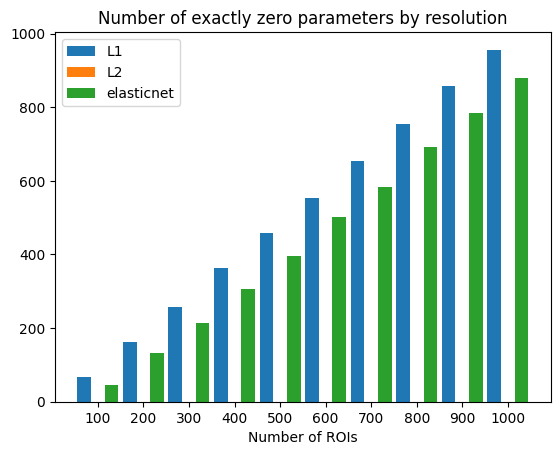

Text(0.5, 0, 'Number of ROIs')

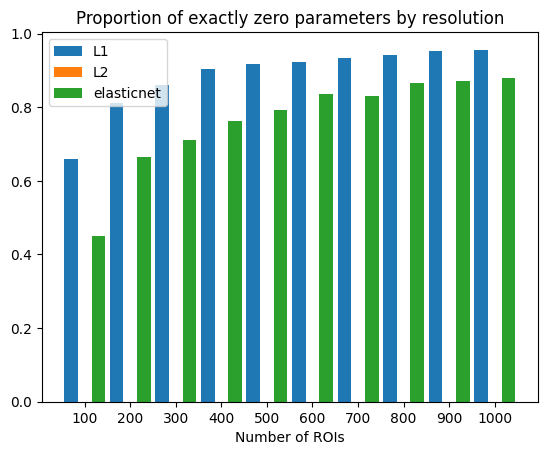

In [5]:
plt.title('Number of exactly zero parameters by resolution');
plt.bar(np.arange(sets_n)-0.3,zero_params_total[0],width=0.3);
plt.bar(np.arange(sets_n),zero_params_total[1],width=0.3);
plt.bar(np.arange(sets_n)+0.3,zero_params_total[2],width=0.3);
plt.legend(['L1','L2','elasticnet']);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel("Number of ROIs")
plt.show()
plt.title('Proportion of exactly zero parameters by resolution');
plt.bar(np.arange(sets_n)-0.3,zero_params_proportion[0],width=0.3);
plt.bar(np.arange(sets_n),zero_params_proportion[1],width=0.3);
plt.bar(np.arange(sets_n)+0.3,zero_params_proportion[2],width=0.3);
plt.legend(['L1','L2','elasticnet']);
plt.xticks(np.arange(sets_n),np.arange(100,1100,100));
plt.xlabel("Number of ROIs")

In [6]:
#Task 3

hyperparam_vals = np.arange(-3,5,0.5)
hyperparam_vals = np.exp(hyperparam_vals)
EIGHTY = round(data_n*0.8)
input = input_variables[-1]
coefficients = np.zeros((hyperparam_vals.size,input.shape[1]))

for i, hyperparam in enumerate(hyperparam_vals):
    model = sklearn.linear_model.LogisticRegression(penalty='l1', C=hyperparam , solver='liblinear' ,max_iter= 10000).fit(input[:EIGHTY],output_variable[:EIGHTY])
    coefficients[i] = model.coef_



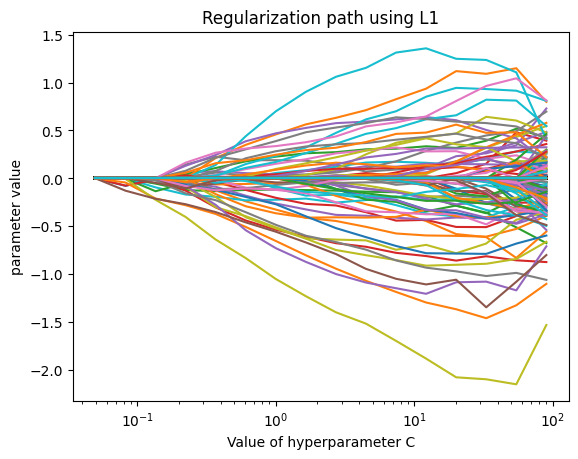

In [7]:
plt.plot(hyperparam_vals,coefficients);
plt.xscale("log")
plt.xlabel("Value of hyperparameter C");
plt.title("Regularization path using L1");
plt.ylabel("parameter value");

At C = 0.05 all coefficients are equal to zero. From 0.05 to 10, coefficients values grow monotonically. For C values greater than 10, the coefficients values show bizzare behaviour. The coefficients values grow and shrink randomly. Many of the coefficients switch between negative and positive values.

In [8]:
#Task 4

EIGHTY = round(data_n*0.8)
nonzero_freq = np.zeros(input_variables[-1].shape[1])

traindata_input = input_variables[-1][:EIGHTY]
traindata_output = output_variable[:EIGHTY]

for i in range(100):
    bs_indices = np.random.randint(EIGHTY,size=EIGHTY)

    input = traindata_input[bs_indices]
    output = traindata_output[bs_indices]

    model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1 , solver='liblinear' ,max_iter= 10000).fit(input,output)

    nonzero_freq = nonzero_freq + (model.coef_ != 0)

nonzero_freq = nonzero_freq.flatten()

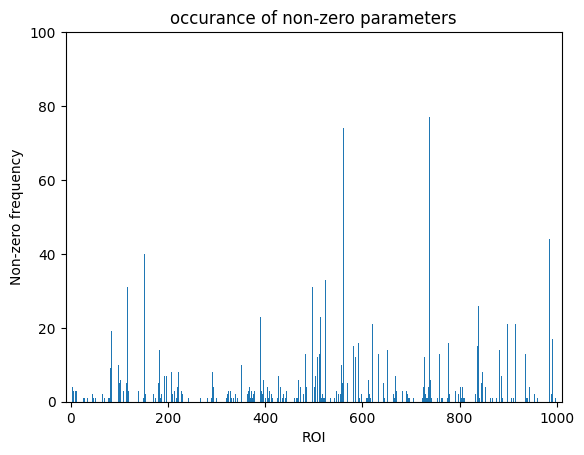

In [9]:
plt.bar(np.arange(0,1000,1),nonzero_freq);
plt.ylim([0,100]);
plt.xlim([-10,nonzero_freq.size+10]);
plt.ylabel('Non-zero frequency');
plt.xlabel('ROI');
plt.title("occurance of non-zero parameters");

In [10]:
#Task 4

np.random.seed(0)

EIGHTY = round(data_n*0.8)
nonzero_freq = np.zeros(input_variables[-1].shape[1])

traindata_input = input_variables[-1][:EIGHTY] + np.random.randn(EIGHTY, input_variables[-1].shape[1]) * 0.1
traindata_output = output_variable[:EIGHTY]

for i in range(100):
    bs_indices = np.random.randint(EIGHTY,size=EIGHTY)

    input = traindata_input[bs_indices]
    output = traindata_output[bs_indices]

    model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1 , solver='liblinear' ,max_iter= 10000).fit(input,output)

    nonzero_freq = nonzero_freq + (model.coef_ != 0)

nonzero_freq = nonzero_freq.flatten()


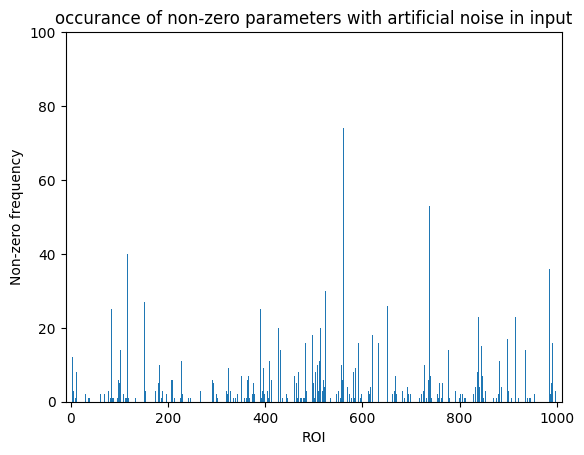

In [11]:
plt.bar(np.arange(0,1000,1),nonzero_freq);
plt.ylim([0,100]);
plt.xlim([-10,nonzero_freq.size+10]);
plt.ylabel('Non-zero frequency');
plt.xlabel('ROI');
plt.title("occurance of non-zero parameters with artificial noise in input");